<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Authors:_ Joseph Nelson (DC), Boom Devahastin Na Ayudhya (NYC), Bethany Poulin (Boston) 

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as timeseries models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_csv('./datasets/train.csv')
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [3]:
data.index

Index(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05',
       '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09',
       ...
       '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14', '2012-09-21',
       '2012-09-28', '2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'],
      dtype='object', name='Date', length=421570)

In [4]:
data.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [5]:
data.index = pd.to_datetime(data.index)

In [6]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**


In [7]:
Weekly_Sales = data.loc[data['Store'] == 1, :]
Weekly_Sales

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False
...,...,...,...,...
2012-08-31,1,99,20.06,False
2012-09-07,1,99,0.05,True
2012-09-14,1,99,0.03,False


In [8]:
Weekly_Sales_1 = pd.DataFrame(Weekly_Sales.groupby('Date').agg(
    Weekly_Sales=pd.NamedAgg(column='Weekly_Sales', aggfunc='sum'),
    IsHoliday=pd.NamedAgg(column='IsHoliday', aggfunc='max')))

In [9]:
Weekly_Sales_1.loc[Weekly_Sales_1.index == '2012-09-07', :].sum()

Weekly_Sales    1661767.33
IsHoliday             1.00
dtype: float64

In [10]:
Weekly_Sales_1

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,1643690.90,False
2010-02-12,1641957.44,True
2010-02-19,1611968.17,False
2010-02-26,1409727.59,False
2010-03-05,1554806.68,False
...,...,...
2012-09-28,1437059.26,False
2012-10-05,1670785.97,False
2012-10-12,1573072.81,False


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

Text(0.5, 1.0, 'Store 1 Weekly Sales')

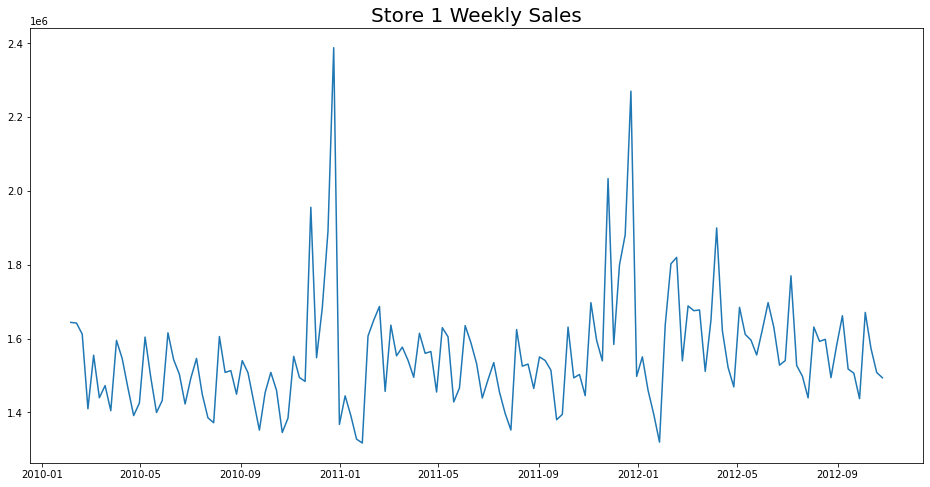

In [11]:
plt.figure(figsize=(16,8))
plt.plot(Weekly_Sales_1['Weekly_Sales'])
plt.title('Store 1 Weekly Sales', fontsize = 20)

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

Text(0.5, 1.0, 'Store 1 Weekly Sales with 4 Weeks Rolling Mean')

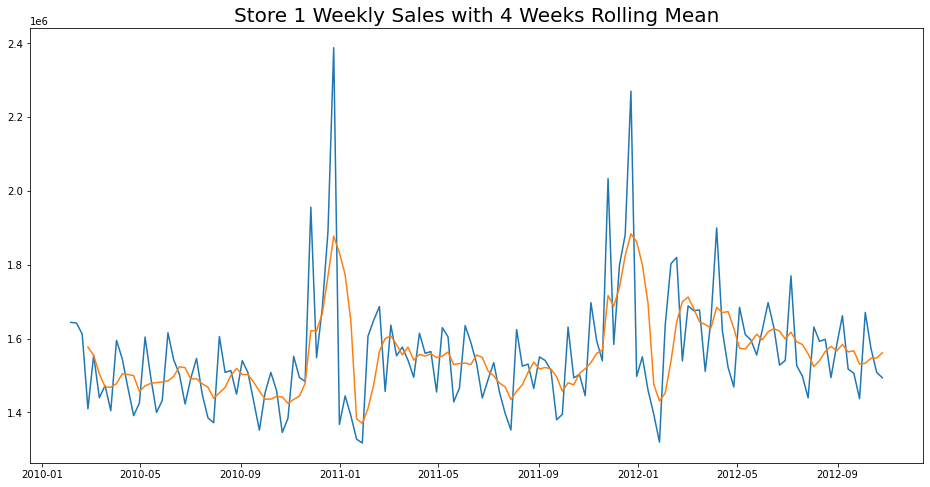

In [12]:
plt.figure(figsize=(16,8))
plt.plot(Weekly_Sales_1['Weekly_Sales'])
plt.plot(Weekly_Sales_1['Weekly_Sales'].rolling(4).mean())
plt.title('Store 1 Weekly Sales with 4 Weeks Rolling Mean', fontsize = 20)

Text(0.5, 1.0, 'Store 1 Weekly Sales with Quarterly Rolling Mean')

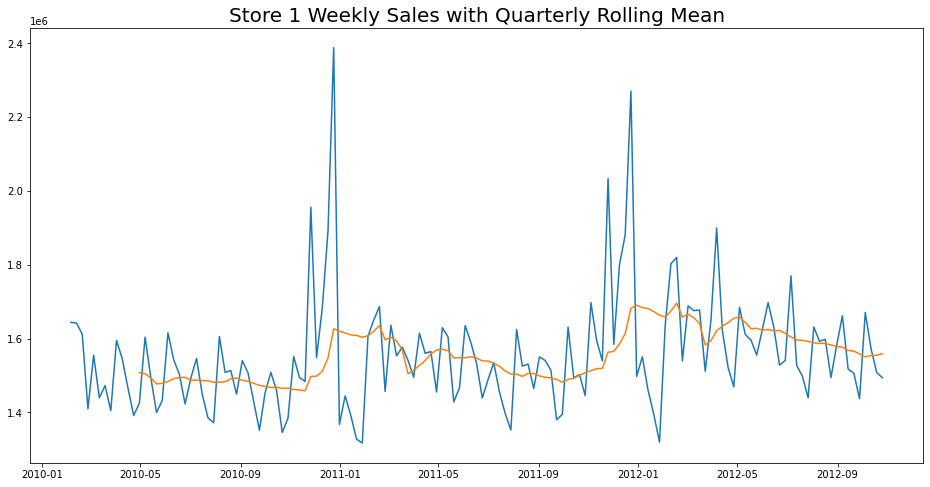

In [13]:
plt.figure(figsize=(16,8))
plt.plot(Weekly_Sales_1['Weekly_Sales'])
plt.plot(Weekly_Sales_1['Weekly_Sales'].rolling(13).mean())
plt.title('Store 1 Weekly Sales with Quarterly Rolling Mean', fontsize = 20)

Text(0.5, 1.0, 'Store 1 Weekly Sales with Yearly Rolling Mean')

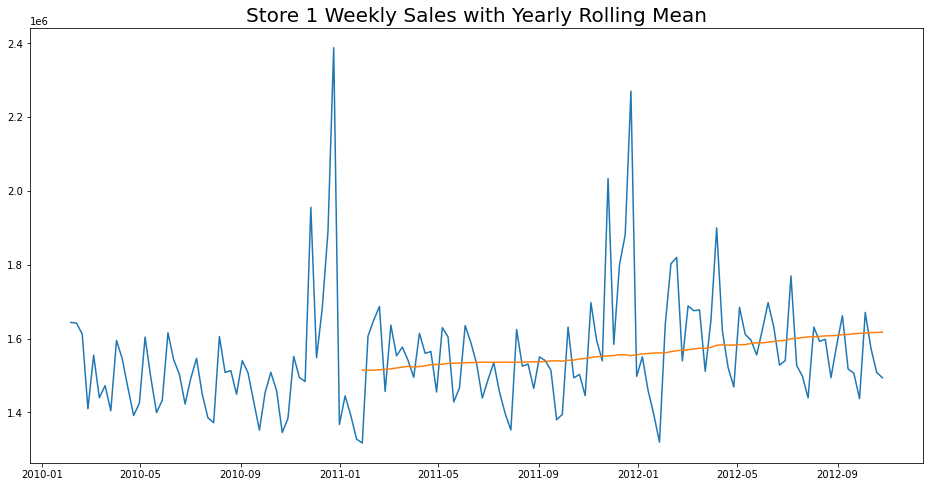

In [14]:
plt.figure(figsize=(16,8))
plt.plot(Weekly_Sales_1['Weekly_Sales'])
plt.plot(Weekly_Sales_1['Weekly_Sales'].rolling(52).mean())
plt.title('Store 1 Weekly Sales with Yearly Rolling Mean', fontsize = 20)

**2c. What can you say about trends in the data based on the rolling mean plot above?**

*Answer:*
From the yearly rolling mean graph, we notice that there is a slight upward trend in sales for store 1

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [15]:
Weekly_Sales_2 = Weekly_Sales_1

In [16]:
Weekly_Sales_2

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,1643690.90,False
2010-02-12,1641957.44,True
2010-02-19,1611968.17,False
2010-02-26,1409727.59,False
2010-03-05,1554806.68,False
...,...,...
2012-09-28,1437059.26,False
2012-10-05,1670785.97,False
2012-10-12,1573072.81,False


In [17]:
Weekly_Sales_2['Weekly_Sales_lag_1'] = Weekly_Sales_2['Weekly_Sales'].shift(1)
Weekly_Sales_2['Weekly_Sales_lag_2'] = Weekly_Sales_2['Weekly_Sales'].shift(2)
Weekly_Sales_2['Weekly_Sales_lag_52'] = Weekly_Sales_2['Weekly_Sales'].shift(52)

In [18]:
Weekly_Sales_2.corr()

,Weekly_Sales,IsHoliday,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_52
Weekly_Sales,1.000000,0.194905,0.302158,0.127413,0.895376
IsHoliday,0.194905,1.000000,0.297243,-0.018275,0.170587
Weekly_Sales_lag_1,0.302158,0.297243,1.000000,0.301574,0.194373
Weekly_Sales_lag_2,0.127413,-0.018275,0.301574,1.000000,0.052809
Weekly_Sales_lag_52,0.895376,0.170587,0.194373,0.052809,1.000000


**3b. What can you say about the series based on these autocorrelations?**

Answer:

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

Make a 52-week `ACF` and 52-week `PACF` plot now.

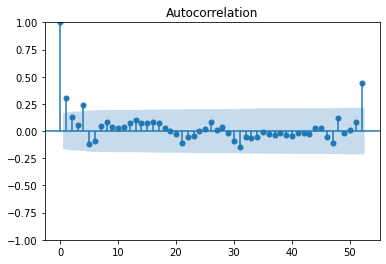

In [19]:
plot_acf(Weekly_Sales_1['Weekly_Sales'], lags = 52);

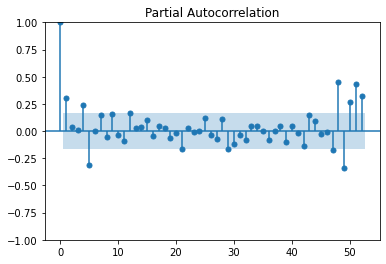

In [20]:
plot_pacf(Weekly_Sales_1['Weekly_Sales'], lags = 52);

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

Answer: Both ACF and PACF have positive first-lag value and sharp cut off

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

Answer: Since there is a sharp cut off in PACF and first-lag of ACF is positive, we can fit AR(1) and AR(2).

## Modeling

**5. Train/Test Split**  

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. Use the first *75%* of observations as training data and the following 25% for test data.

In [21]:
train = Weekly_Sales_1.iloc[0:108]

test = Weekly_Sales_1.iloc[108:]

In [22]:
train

,Weekly_Sales,IsHoliday,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_52
Date,,,,,
2010-02-05,1643690.90,False,NaN,NaN,NaN
2010-02-12,1641957.44,True,1643690.90,NaN,NaN
2010-02-19,1611968.17,False,1641957.44,1643690.90,NaN
2010-02-26,1409727.59,False,1611968.17,1641957.44,NaN
2010-03-05,1554806.68,False,1409727.59,1611968.17,NaN
...,...,...,...,...,...
2012-01-27,1319325.59,False,1394393.84,1459601.17,1316899.31
2012-02-03,1636339.65,False,1319325.59,1394393.84,1606629.58
2012-02-10,1802477.43,True,1636339.65,1319325.59,1649614.93


In [23]:
test.shape

(35, 5)

#### 6. Autoregressive Model

We will start by building a simple autoregressive model first: the `AR(1)` model. In each section, we will add additional ARIMA parameters in an effort to improve our modeling. Note that sometimes the model you attempt is not effective or the best -- try the BONUS sections below to see other approaches to modeling this dataset!

- Note that this is the same thing as an `ARIMA(1,0,0)` model.
- Pass in the Weekly Sales as an `ndarray`, not a `Series`.
- Pass in the training index using the ARIMA `dates` parameter.

**6a. Instantiate and fit an `AR(1)` model.**

In [24]:
ar1 = ARIMA(endog = train['Weekly_Sales'],
            order = (1, 0, 0)) # (p, d, q)

# Fit AR(1) model.
model = ar1.fit()

preds = model.predict(start=108, end=142)

**6b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [25]:
mean_squared_error(test['Weekly_Sales'], preds)

11496534849.29018

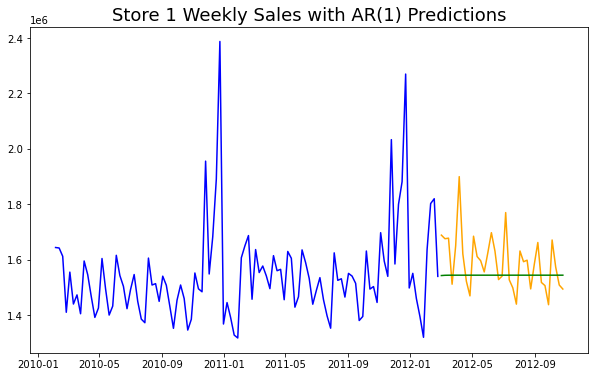

In [26]:
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR(1) Predictions', fontsize=18)
plt.show();

**6c. How effective do you think this `AR(1)` model is?**

Answer: It is not effective at predicting weekly sales

#### 7. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**7a. Calculate and and plot the residuals of your `AR(1)` model. (*Remember that a residual is just the actual value minus the predicted value.*)**

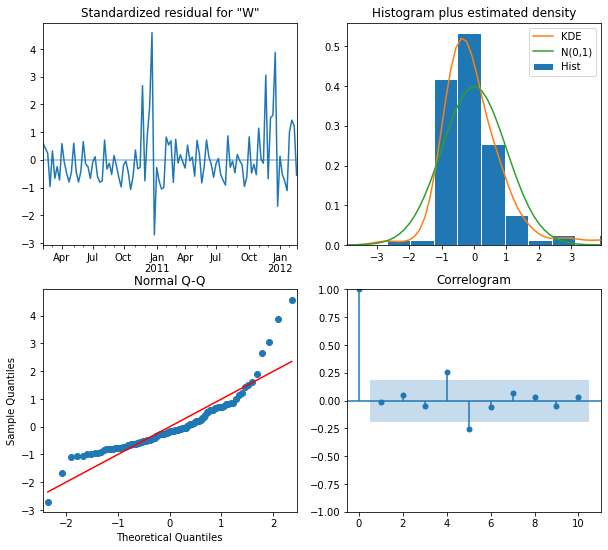

In [27]:
model.plot_diagnostics(figsize=(10,9))
plt.show()

From this plot we can see that there are clearly errors in our predictions. 

**7b. What do the residual plots reveal about our model?**

Answer:
- Top left: The residual errors seem to fluctuate around a mean of zero and have a huge variance around Jan.

- Top Right: The density plot suggest slightly right skewed distribution.

- Bottom left: As expected, the dots did not fall in line with the red line. Any significant deviations would imply the distribution is skewed.

- Bottom Right: The Correlogram shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.



#### 8. AR vs. ARMA Models 


**8a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

In [28]:
ar2 = ARIMA(endog = train['Weekly_Sales'],
            order = (2, 0, 0)) # (p, d, q)

# Fit AR(2) model.
model2 = ar2.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds2 = model2.predict(start=108, end=142)

In [29]:
mean_squared_error(test['Weekly_Sales'], preds2)

11333914061.72471

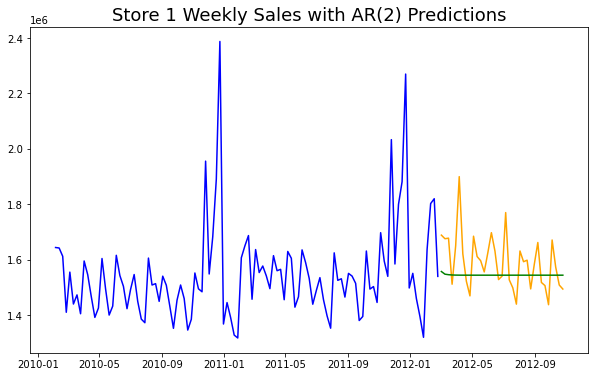

In [30]:
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds2, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with AR(2) Predictions', fontsize=18)
plt.show();

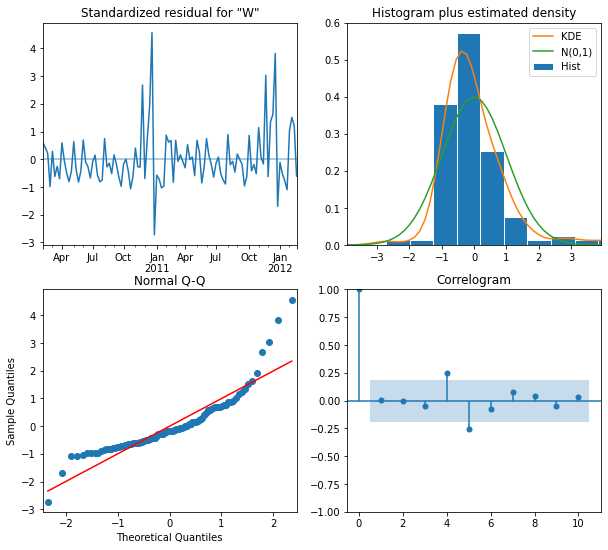

In [31]:
model2.plot_diagnostics(figsize=(10,9))
plt.show()

**8b. How did your results change?**

Answer: There is no significant changes from AR(1) and AR(2).

**8c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

In [32]:
arma = ARIMA(endog = train['Weekly_Sales'],
            order = (2, 0, 2)) # (p, d, q)

# Fit AR(2) model.
model3 = arma.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds3 = model3.predict(start=108, end=142)

In [33]:
mean_squared_error(test['Weekly_Sales'], preds3)

11379217185.857962

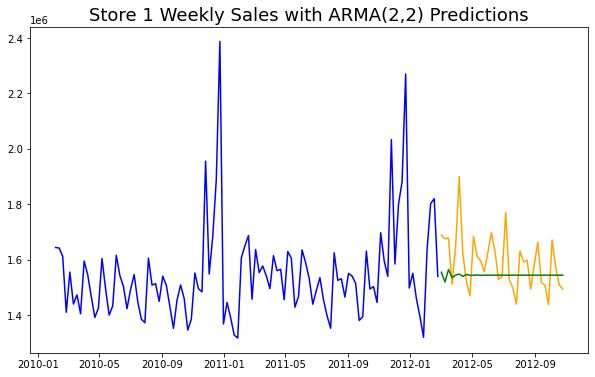

In [34]:
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds3, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with ARMA(2,2) Predictions', fontsize=18)
plt.show();

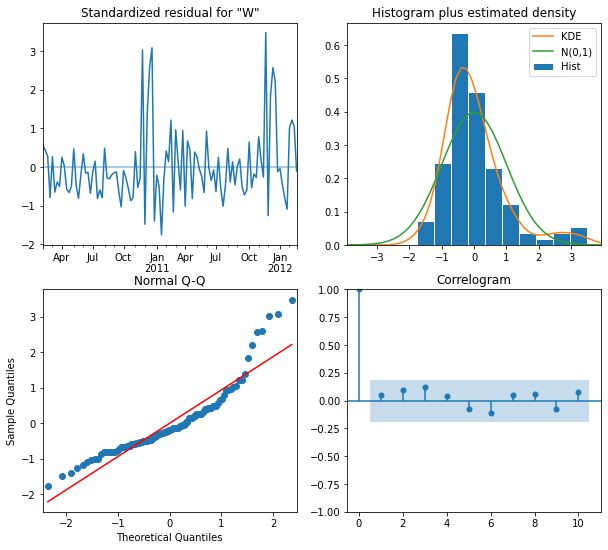

In [35]:
model3.plot_diagnostics(figsize=(10,9))
plt.show()

**8d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Answer:
- Top left: The residual errors seem to fluctuate around a mean of less than zero and have a huge variance around Nov/Dec.

- Top Right: The density plot suggest obvious right skewed distribution with a mean closer to -0.5.

#### 9. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**9a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [36]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [37]:
interpret_dftest(adfuller(Weekly_Sales_1['Weekly_Sales']))

Test Statistic   -5.102186
p-value           0.000014
dtype: float64

**9b. Interpret the results of the Augmented Dickey-Fuller test.**

Answer: low p-value means that we reject the null hypothesis and classify this as stationary.

#### 10. Differenced Data

**10a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [38]:
Weekly_Sales_3 = Weekly_Sales_1

In [39]:
Weekly_Sales_3['Weekly_Sales_diff_1'] = Weekly_Sales_3['Weekly_Sales'].diff()
Weekly_Sales_3['Weekly_Sales_diff_2'] = Weekly_Sales_3['Weekly_Sales'].diff().diff()
Weekly_Sales_3['Weekly_Sales_diff_3'] = Weekly_Sales_3['Weekly_Sales'].diff().diff().diff()
Weekly_Sales_3['Weekly_Sales_diff_4'] = Weekly_Sales_3['Weekly_Sales'].diff().diff().diff().diff()
Weekly_Sales_3

,Weekly_Sales,IsHoliday,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_52,Weekly_Sales_diff_1,Weekly_Sales_diff_2,Weekly_Sales_diff_3,Weekly_Sales_diff_4
Date,,,,,,,,,
2010-02-05,1643690.90,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-12,1641957.44,True,1643690.90,NaN,NaN,-1733.46,NaN,NaN,NaN
2010-02-19,1611968.17,False,1641957.44,1643690.90,NaN,-29989.27,-28255.81,NaN,NaN
2010-02-26,1409727.59,False,1611968.17,1641957.44,NaN,-202240.58,-172251.31,-143995.50,NaN
2010-03-05,1554806.68,False,1409727.59,1611968.17,NaN,145079.09,347319.67,519570.98,663566.48
...,...,...,...,...,...,...,...,...,...
2012-09-28,1437059.26,False,1506126.06,1517428.87,1394561.83,-69066.80,-57763.99,-190799.64,-547857.68
2012-10-05,1670785.97,False,1437059.26,1506126.06,1630989.95,233726.71,302793.51,360557.50,551357.14
2012-10-12,1573072.81,False,1670785.97,1437059.26,1493525.93,-97713.16,-331439.87,-634233.38,-994790.88


In [40]:
Weekly_Sales_3 = Weekly_Sales_3.drop('IsHoliday', axis=1)

**10b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [41]:
interpret_dftest(adfuller(Weekly_Sales_3['Weekly_Sales_diff_1'].dropna()))

Test Statistic   -7.261575e+00
p-value           1.676180e-10
dtype: float64

In [42]:
interpret_dftest(adfuller(Weekly_Sales_3['Weekly_Sales_diff_2'].dropna()))

Test Statistic   -6.517398e+00
p-value           1.062879e-08
dtype: float64

In [43]:
interpret_dftest(adfuller(Weekly_Sales_3['Weekly_Sales_diff_3'].dropna()))

Test Statistic   -6.858902e+00
p-value           1.621469e-09
dtype: float64

In [44]:
interpret_dftest(adfuller(Weekly_Sales_3['Weekly_Sales_diff_4'].dropna()))

Test Statistic   -7.786634e+00
p-value           8.146853e-12
dtype: float64

**10c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

Answer: All results p-value are > 0.05, thus fail to reject null hypothesis and is non-stationary. 

**10d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Answer: Yes. we can use differenced data to achieve stationary

#### 11.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**11a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

In [45]:
arima = ARIMA(endog = train['Weekly_Sales'],
            order = (2, 1, 2)) # (p, d, q)

# Fit AR(2) model.
model4 = arima.fit()

# Generate predictions based on test set.
# Start at time period 150 and end at 187.
preds4 = model4.predict(start=108, end=142)

In [46]:
mean_squared_error(test['Weekly_Sales'], preds4)

10598177156.638456

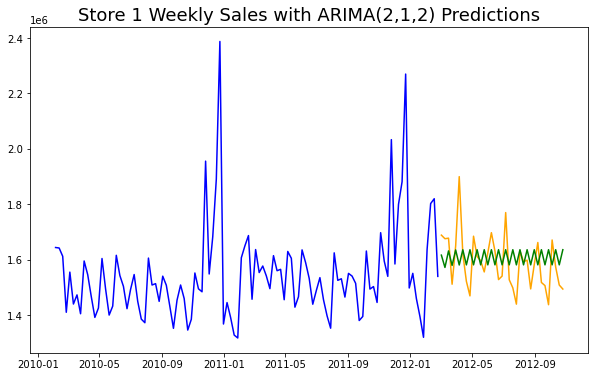

In [47]:
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds4, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with ARIMA(2,1,2) Predictions', fontsize=18)
plt.show();

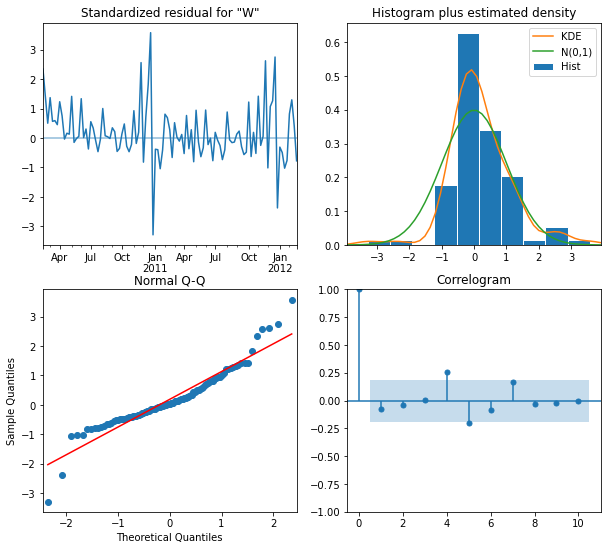

In [48]:
model4.plot_diagnostics(figsize=(10,9))
plt.show()

**11b. Interpret the results from the last answer.**


Answer:
- Top left: The residual errors seem to fluctuate around a mean of zero and have a huge variance around Jan.

- Top Right: The density plot suggest slightly normal distribution with a mean between -0.5 and 0.

- Bottom left: More dots closer to the red line implying the distribution is closer to normal distribution.



#### 12.  SARIMAX Model
We have looked at autocorrelation of neighboring values (i.e. comparing $Y_t$ to $Y_{t-1}$ or $Y_t$ to $Y_{t-4}$). However, what about seasonal affects on our data? How might the sales today be related to sales 6 months ago or a year ago?

Let's build a SARIMAX model!

**12a. Using `PACF` and `ACF` plots with appropriate intervals (think months in a year) try to build the best SARIMAX model you can in setting the `seasonal_order = (P, D, Q, S)` and using `order = (2, 0, 2)`, fit and evaluate the model as we have done in the prior models**.

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [50]:
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            try:
                # Instantiate SARIMA model.
                sarima = SARIMAX(endog = train['Weekly_Sales'],
                                 order = (2, 0, 2),              # (p, d, q)
                                 seasonal_order = (P, D, Q, 52)) # (P, D, Q, S)

                # Fit SARIMA model.
                model5 = sarima.fit()

            
                preds5 = model5.predict(start=108, end=142)

                # Evaluate predictions.
                print(f"The MSE for (2, 0, 2)x({P},{D},{Q},52) is: {mean_squared_error(train['Weekly_Sales'], preds5)}")
                
                # Save for final report.
                if mse > mean_squared_error(train['Weekly_Sales'], preds5):
                    mse = mean_squared_error(train['Weekly_Sales'], preds5)
                    final_P = P
                    final_D = D
                    final_Q = Q
                
            except:
                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA(2, 0, 2)x({final_P},{final_D},{final_Q},52).')
print(f'This model has an MSE of {mse}.')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01

At iterate    5    f=  1.37408D+01    |proj g|=  1.99594D-01

At iterate   10    f=  1.34951D+01    |proj g|=  9.92040D-03

At iterate   15    f=  1.34805D+01    |proj g|=  1.10457D-03

At iterate   20    f=  1.34800D+01    |proj g|=  6.84210D-04

At iterate   25    f=  1.34787D+01    |proj g|=  1.25928D-03

At iterate   30    f=  1.34784D+01    |proj g|=  1.47639D-04

At iterate   35    f=  1.34783D+01    |proj g|=  2.91062D-04

At iterate   40    f=  1.34783D+01    |proj g|=  1.37360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61785D+00    |proj g|=  2.84014D-01


 This problem is unconstrained.



At iterate    5    f=  6.45144D+00    |proj g|=  1.55444D-01

At iterate   10    f=  6.44680D+00    |proj g|=  1.28021D-02

At iterate   15    f=  6.44531D+00    |proj g|=  3.19994D-03

At iterate   20    f=  6.44528D+00    |proj g|=  9.05940D-04

At iterate   25    f=  6.44525D+00    |proj g|=  3.57822D-03

At iterate   30    f=  6.44516D+00    |proj g|=  4.48968D-03

At iterate   35    f=  6.44482D+00    |proj g|=  1.52509D-02

At iterate   40    f=  6.44368D+00    |proj g|=  9.90409D-03

At iterate   45    f=  6.44152D+00    |proj g|=  3.94001D-02

At iterate   50    f=  6.44011D+00    |proj g|=  4.80524D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.38804D-01    |proj g|=  9.90622D-02

At iterate   10    f=  4.21753D-01    |proj g|=  6.38429D-02

At iterate   15    f=  4.20995D-01    |proj g|=  4.46491D-03

At iterate   20    f=  4.20774D-01    |proj g|=  6.79716D-02

At iterate   25    f=  4.20205D-01    |proj g|=  8.74662D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  4.20203D-01    |proj g|=  1.13188D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32    100      3     0     0   2.259D-04   4.202D-01
  F =  0.42020280067978244     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01

At iterate    5    f=  1.35308D+01    |proj g|=  1.58979D-01


 This problem is unconstrained.



At iterate   10    f=  1.33685D+01    |proj g|=  1.49685D-02

At iterate   15    f=  1.33582D+01    |proj g|=  2.27250D-03

At iterate   20    f=  1.33580D+01    |proj g|=  1.83008D-04

At iterate   25    f=  1.33572D+01    |proj g|=  2.03602D-03

At iterate   30    f=  1.33570D+01    |proj g|=  2.21872D-03

At iterate   35    f=  1.33569D+01    |proj g|=  2.98115D-04

At iterate   40    f=  1.33569D+01    |proj g|=  2.53682D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   2.537D-06   1.336D+01
  F =   13.356895974330653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61785D+00    |proj g|=  8.46929D+00

At iterate    5    f=  6.49032D+00    |proj g|=  2.48393D-02

At iterate   10    f=  6.49027D+00    |proj g|=  1.97363D-02

At iterate   15    f=  6.49005D+00    |proj g|=  3.47045D-02

At iterate   20    f=  6.48996D+00    |proj g|=  2.27530D-03

At iterate   25    f=  6.48988D+00    |proj g|=  6.04509D-02

At iterate   30    f=  6.48805D+00    |proj g|=  9.89166D-02

At iterate   35    f=  6.47290D+00    |proj g|=  1.04217D-01

At iterate   40    f=  6.47182D+00    |proj g|=  1.05824D-01

At iterate   45    f=  6.47088D+00    |proj g|=  2.92954D-01

At iterate   50    f=  6.46631D+00    |proj g|=  2.21543D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.20785D-01    |proj g|=  1.09066D-01

At iterate   10    f=  4.20467D-01    |proj g|=  1.03553D-02

At iterate   15    f=  4.20241D-01    |proj g|=  3.53343D-02

At iterate   20    f=  4.20202D-01    |proj g|=  8.76960D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     44      1     0     0   8.770D-04   4.202D-01
  F =  0.42020218702599832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01


 This problem is unconstrained.



At iterate    5    f=  1.34799D+01    |proj g|=  1.31825D-01

At iterate   10    f=  1.33432D+01    |proj g|=  1.23971D-02

At iterate   15    f=  1.33348D+01    |proj g|=  2.34676D-03

At iterate   20    f=  1.33345D+01    |proj g|=  1.04270D-04

At iterate   25    f=  1.33345D+01    |proj g|=  1.38900D-03

At iterate   30    f=  1.33342D+01    |proj g|=  5.03724D-03

At iterate   35    f=  1.33340D+01    |proj g|=  1.71555D-03

At iterate   40    f=  1.33339D+01    |proj g|=  1.20008D-03

At iterate   45    f=  1.33339D+01    |proj g|=  1.62534D-04

At iterate   50    f=  1.33339D+01    |proj g|=  2.76778D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.43858D+00    |proj g|=  4.69984D-01

At iterate   10    f=  6.43812D+00    |proj g|=  8.53420D-03

At iterate   15    f=  6.43798D+00    |proj g|=  8.68259D-02

At iterate   20    f=  6.43743D+00    |proj g|=  1.14166D-02

At iterate   25    f=  6.43742D+00    |proj g|=  7.10861D-03

At iterate   30    f=  6.43736D+00    |proj g|=  1.19701D-01

At iterate   35    f=  6.43703D+00    |proj g|=  4.60180D-02

At iterate   40    f=  6.43639D+00    |proj g|=  3.34692D-01

At iterate   45    f=  6.42913D+00    |proj g|=  6.62661D-01

At iterate   50    f=  6.41252D+00    |proj g|=  1.12877D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.20618D-01    |proj g|=  1.42270D-01

At iterate   10    f=  4.20464D-01    |proj g|=  3.20342D-03

At iterate   15    f=  4.20302D-01    |proj g|=  2.95201D-02

At iterate   20    f=  4.20202D-01    |proj g|=  4.59612D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     42      1     0     0   4.596D-04   4.202D-01
  F =  0.42020219601825715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01


 This problem is unconstrained.



At iterate    5    f=  1.34546D+01    |proj g|=  1.29257D-01

At iterate   10    f=  1.33292D+01    |proj g|=  1.66486D-02

At iterate   15    f=  1.33244D+01    |proj g|=  1.53213D-03

At iterate   20    f=  1.33243D+01    |proj g|=  2.09934D-04

At iterate   25    f=  1.33243D+01    |proj g|=  1.48199D-03

At iterate   30    f=  1.33242D+01    |proj g|=  6.12583D-04

At iterate   35    f=  1.33240D+01    |proj g|=  1.79421D-03

At iterate   40    f=  1.33240D+01    |proj g|=  4.07622D-04

At iterate   45    f=  1.33240D+01    |proj g|=  5.95943D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     56   

 This problem is unconstrained.



At iterate    5    f=  6.48941D+00    |proj g|=  2.83439D-01

At iterate   10    f=  6.48891D+00    |proj g|=  1.91890D-01

At iterate   15    f=  6.48882D+00    |proj g|=  1.15366D-02

At iterate   20    f=  6.48874D+00    |proj g|=  1.33344D-01

At iterate   25    f=  6.48852D+00    |proj g|=  3.00938D-03

At iterate   30    f=  6.48851D+00    |proj g|=  7.04998D-03

At iterate   35    f=  6.48831D+00    |proj g|=  3.64432D-02

At iterate   40    f=  6.48467D+00    |proj g|=  3.58500D-01

At iterate   45    f=  6.47076D+00    |proj g|=  7.05770D-02

At iterate   50    f=  6.46966D+00    |proj g|=  3.71323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.20545D-01    |proj g|=  1.02133D-01

At iterate   10    f=  4.20463D-01    |proj g|=  9.52952D-03

At iterate   15    f=  4.20218D-01    |proj g|=  1.35566D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  4.20202D-01    |proj g|=  1.57717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     57      2     0     0   1.577D-04   4.202D-01
  F =  0.42020218076455546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01

At iterate    5    f=  1.34708D+01    |proj g|=  1.23220D-01

At iterate   10    f=  1.33307D+01    |proj g|=  2.12408D-02

At iterate   15    f=  1.33250D+01    |proj g|=  6.50612D-03

At iterate   20    f=  1.33243D+01    |proj g|=  9.30649D-05

At iterate   25    f=  1.33243D+01    |proj g|=  2.15078D-04

At iterate   30    f=  1.33242D+01    |proj g|=  8.55833D-04

At iterate   35    f=  1.33241D+01    |proj g|=  7.97246D-04

At iterate   40    f=  1.33240D+01    |proj g|=  3.38125D-04

At iterate   45    f=  1.33240D+01    |proj g|=  4.09464D-04

At iterate   50    f=  1.33240D+01    |proj g|=  5.39215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61785D+00    |proj g|=  8.47227D+00

At iterate    5    f=  6.48989D+00    |proj g|=  8.82114D-02

At iterate   10    f=  6.48922D+00    |proj g|=  2.24461D-01

At iterate   15    f=  6.48896D+00    |proj g|=  2.86465D-01

At iterate   20    f=  6.48145D+00    |proj g|=  1.39682D+00

At iterate   25    f=  6.46356D+00    |proj g|=  3.37100D-01

At iterate   30    f=  6.45676D+00    |proj g|=  1.37988D-01

At iterate   35    f=  6.45416D+00    |proj g|=  3.28791D-02

At iterate   40    f=  6.45297D+00    |proj g|=  1.53047D-02

At iterate   45    f=  6.45197D+00    |proj g|=  1.41043D-02

At iterate   50    f=  6.45161D+00    |proj g|=  2.71823D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42944D-01    |proj g|=  3.95649D+00

At iterate    5    f=  4.21617D-01    |proj g|=  2.97167D-01

At iterate   10    f=  4.20477D-01    |proj g|=  2.76456D-03

At iterate   15    f=  4.20375D-01    |proj g|=  2.88721D-02

At iterate   20    f=  4.20202D-01    |proj g|=  6.85707D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     45      1     0     0   8.960D-04   4.202D-01
  F =  0.42020217526303871     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01

At iterate    5    f=  1.34742D+01    |proj g|=  1.21583D-01

At iterate   10    f=  1.33283D+01    |proj g|=  9.39597D-03

At iterate   15    f=  1.33253D+01    |proj g|=  3.46385D-03

At iterate   20    f=  1.33243D+01    |proj g|=  1.46206D-04

At iterate   25    f=  1.33243D+01    |proj g|=  2.12430D-04

At iterate   30    f=  1.33243D+01    |proj g|=  2.22904D-03

At iterate   35    f=  1.33242D+01    |proj g|=  1.35870D-03

At iterate   40    f=  1.33241D+01    |proj g|=  1.65943D-03

At iterate   45    f=  1.33240D+01    |proj g|=  1.02497D-03

At iterate   50    f=  1.33240D+01    |proj g|=  5.49857D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61785D+00    |proj g|=  8.47227D+00

At iterate    5    f=  6.43991D+00    |proj g|=  9.76508D-01

At iterate   10    f=  6.43812D+00    |proj g|=  2.95354D-02

At iterate   15    f=  6.43811D+00    |proj g|=  4.38637D-02

At iterate   20    f=  6.43808D+00    |proj g|=  6.53638D-02

At iterate   25    f=  6.43775D+00    |proj g|=  2.85547D-01

At iterate   30    f=  6.43748D+00    |proj g|=  8.61885D-03

At iterate   35    f=  6.43746D+00    |proj g|=  3.36157D-02

At iterate   40    f=  6.43743D+00    |proj g|=  4.94746D-02

At iterate   45    f=  6.43731D+00    |proj g|=  4.46157D-02

At iterate   50    f=  6.43713D+00    |proj g|=  1.17485D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  4.20540D-01    |proj g|=  6.28983D-02

At iterate   10    f=  4.20468D-01    |proj g|=  5.22463D-03

At iterate   15    f=  4.20370D-01    |proj g|=  8.16285D-02

At iterate   20    f=  4.20202D-01    |proj g|=  1.03718D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     48      2     0     0   8.365D-04   4.202D-01
  F =  0.42020219939299619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01


 This problem is unconstrained.



At iterate    5    f=  1.34549D+01    |proj g|=  1.28625D-01

At iterate   10    f=  1.33303D+01    |proj g|=  2.16937D-02

At iterate   15    f=  1.33248D+01    |proj g|=  1.42169D-02

At iterate   20    f=  1.33243D+01    |proj g|=  1.01295D-04

At iterate   25    f=  1.33243D+01    |proj g|=  8.32713D-04

At iterate   30    f=  1.33243D+01    |proj g|=  9.63822D-04

At iterate   35    f=  1.33241D+01    |proj g|=  6.65664D-04

At iterate   40    f=  1.33241D+01    |proj g|=  1.35998D-03

At iterate   45    f=  1.33240D+01    |proj g|=  1.89114D-04

At iterate   50    f=  1.33240D+01    |proj g|=  1.12025D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.43815D+00    |proj g|=  7.24943D-02

At iterate   10    f=  6.43810D+00    |proj g|=  8.38564D-03

At iterate   15    f=  6.43758D+00    |proj g|=  2.78681D-02

At iterate   20    f=  6.43742D+00    |proj g|=  1.20154D-03

At iterate   25    f=  6.43742D+00    |proj g|=  9.19091D-03

At iterate   30    f=  6.43643D+00    |proj g|=  1.55142D-01

At iterate   35    f=  6.42897D+00    |proj g|=  4.57965D-01

At iterate   40    f=  6.42506D+00    |proj g|=  8.11381D-02

At iterate   45    f=  6.42450D+00    |proj g|=  1.37661D-01

At iterate   50    f=  6.42079D+00    |proj g|=  9.53068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.21289D-01    |proj g|=  3.30775D-01

At iterate   10    f=  4.20461D-01    |proj g|=  3.11296D-03

At iterate   15    f=  4.20398D-01    |proj g|=  4.65681D-02

At iterate   20    f=  4.20205D-01    |proj g|=  7.39578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     44      1     0     0   4.746D-04   4.202D-01
  F =  0.42020243567776600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01


 This problem is unconstrained.



At iterate    5    f=  1.34541D+01    |proj g|=  1.16387D-01

At iterate   10    f=  1.33305D+01    |proj g|=  2.09724D-02

At iterate   15    f=  1.33250D+01    |proj g|=  5.27630D-03

At iterate   20    f=  1.33243D+01    |proj g|=  1.21255D-04

At iterate   25    f=  1.33243D+01    |proj g|=  1.93636D-04

At iterate   30    f=  1.33243D+01    |proj g|=  3.65798D-03

At iterate   35    f=  1.33241D+01    |proj g|=  9.04076D-04

At iterate   40    f=  1.33240D+01    |proj g|=  7.30428D-04

At iterate   45    f=  1.33240D+01    |proj g|=  5.78817D-04

At iterate   50    f=  1.33240D+01    |proj g|=  2.60843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61785D+00    |proj g|=  8.47227D+00

At iterate    5    f=  6.43989D+00    |proj g|=  9.39969D-01

At iterate   10    f=  6.43812D+00    |proj g|=  6.31197D-03

At iterate   15    f=  6.43811D+00    |proj g|=  3.90539D-02

At iterate   20    f=  6.43807D+00    |proj g|=  1.29806D-01

At iterate   25    f=  6.43765D+00    |proj g|=  3.07788D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     48      1     0     0   1.717D-02   6.437D+00
  F =   6.4374541837106616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42944D-01    |proj g|=  3.99088D+00

At iterate    5    f=  4.21923D-01    |proj g|=  4.16659D-01

At iterate   10    f=  4.20469D-01    |proj g|=  3.39682D-03

At iterate   15    f=  4.20407D-01    |proj g|=  3.73061D-02

At iterate   20    f=  4.20203D-01    |proj g|=  1.97559D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     48      2     0     0   4.126D-04   4.202D-01
  F =  0.42020236850607851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01

At iterate    5    f=  1.34668D+01    |proj g|=  1.17887D-01

At iterate   10    f=  1.33303D+01    |proj g|=  2.34333D-02

At iterate   15    f=  1.33255D+01    |proj g|=  8.29717D-03

At iterate   20    f=  1.33243D+01    |proj g|=  1.58953D-03

At iterate   25    f=  1.33243D+01    |proj g|=  1.09196D-04

At iterate   30    f=  1.33243D+01    |proj g|=  2.96391D-04

At iterate   35    f=  1.33243D+01    |proj g|=  2.74216D-03

At iterate   40    f=  1.33241D+01    |proj g|=  1.19967D-03

At iterate   45    f=  1.33240D+01    |proj g|=  1.22728D-03

At iterate   50    f=  1.33240D+01    |proj g|=  5.73780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.44134D+00    |proj g|=  6.42993D-01

At iterate   10    f=  6.43812D+00    |proj g|=  3.57667D-02

At iterate   15    f=  6.43812D+00    |proj g|=  2.61337D-02

At iterate   20    f=  6.43781D+00    |proj g|=  1.95832D-01

At iterate   25    f=  6.43747D+00    |proj g|=  7.88869D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  6.43746D+00    |proj g|=  5.63986D-03

At iterate   35    f=  6.43745D+00    |proj g|=  9.30757D-03

At iterate   40    f=  6.43744D+00    |proj g|=  4.86683D-02

At iterate   45    f=  6.43743D+00    |proj g|=  7.31148D-02

At iterate   50    f=  6.43742D+00    |proj g|=  4.04448D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    113      2     0     0   4.044D-02   6.437D+00
  F =   6.4374168295916885     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.42944D-01    |proj g|=  3.99088D+00

At iterate    5    f=  4.20614D-01    |proj g|=  1.24926D-01

At iterate   10    f=  4.20461D-01    |proj g|=  6.27171D-03

At iterate   15    f=  4.20241D-01    |proj g|=  2.38584D-02

At iterate   20    f=  4.20202D-01    |proj g|=  5.55457D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     34      1     0     0   3.022D-03   4.202D-01
  F =  0.42020235756472524     

CONVERG

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34755D+01    |proj g|=  7.95488D+01

At iterate    5    f=  1.37408D+01    |proj g|=  1.99594D-01

At iterate   10    f=  1.34951D+01    |proj g|=  9.92040D-03

At iterate   15    f=  1.34805D+01    |proj g|=  1.10457D-03

At iterate   20    f=  1.34800D+01    |proj g|=  6.84210D-04

At iterate   25    f=  1.34787D+01    |proj g|=  1.25928D-03

At iterate   30    f=  1.34784D+01    |proj g|=  1.47639D-04

At iterate   35    f=  1.34783D+01    |proj g|=  2.91062D-04

At iterate   40    f=  1.34783D+01    |proj g|=  1.37360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


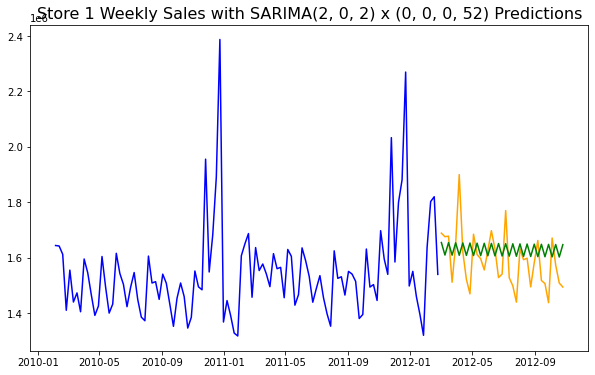

In [54]:
sarima2 = SARIMAX(endog = train['Weekly_Sales'],
                 order = (2, 0, 2),              # (p, d, q)
                 seasonal_order = (0, 0, 0, 52)) # (P, D, Q, S)

# Fit SARIMA model.
model6 = sarima2.fit()

# Generate predictions based on test set.
preds6 = model6.predict(start=108, end=142)

# Evaluate predictions.
print(mean_squared_error(test['Weekly_Sales'], preds6))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds6, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with SARIMA(2, 0, 2) x (0, 0, 0, 52) Predictions', fontsize=16)
plt.show();

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35632D+01    |proj g|=  1.65441D+00

At iterate    5    f=  1.34990D+01    |proj g|=  4.05792D-01

At iterate   10    f=  1.34799D+01    |proj g|=  2.88061D-01

At iterate   15    f=  1.34428D+01    |proj g|=  3.01733D+00

At iterate   20    f=  1.34220D+01    |proj g|=  9.53361D-02

At iterate   25    f=  1.34207D+01    |proj g|=  1.38423D-01

At iterate   30    f=  1.34201D+01    |proj g|=  2.42611D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

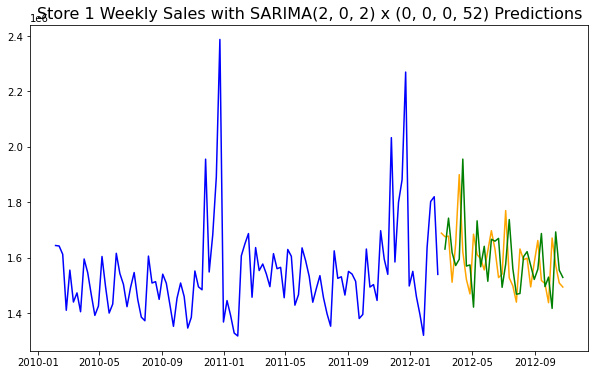

In [56]:
sarima3 = SARIMAX(endog = train['Weekly_Sales'].iloc[1:],
                 order = (2, 0, 2),              # (p, d, q)
                 seasonal_order = (0, 0, 0, 52), # (P, D, Q, S)
                 exog = train['Weekly_Sales_lag_1'].iloc[1:])

# Fit SARIMA model.
model7 = sarima3.fit()

# Generate predictions based on test set.
preds7 = model7.predict(start=108, end=141, exog=test[['Weekly_Sales_lag_1']])

# Evaluate predictions.
print(mean_squared_error(test['Weekly_Sales'].iloc[1:], preds7))

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(train['Weekly_Sales'], color = 'blue')
plt.plot(test['Weekly_Sales'], color = 'orange')
plt.plot(preds7, color = 'green')
plt.title(label = 'Store 1 Weekly Sales with SARIMA(2, 0, 2) x (0, 0, 0, 52) Predictions', fontsize=16)
plt.show();

**12b. How did your best SARIMAX model perform?**

Answer: First model not much difference from ARIMAX but it is not very good at predicting. After eXogenous Predictors, we notice that it is quite close to the actual data.

### 13. Your Best Model

**13a. In the cells below, bring together your best model, including:**
- any summaries, 
- graphs of the data and residuals, 
- the predictions,
- and how you decided this was your best model.

Best model is SARIMAX with eXogenous Predictors, and with ACF and PACF, we can identify that the data has seasonal component.

**13b. How does our model perform at predicting weekly sales moving forward?** 

Answer: It seems quite accurate how ever with the lag its predicting ahead.

**13c. How might you improve it?**

Answer: Fix the lag prediction

### 14. BONUS: Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

Answer: